https://www.tensorflow.org/tutorials/text/text_classification_rnn

# 使用 RNN 进行文本分类
此文本分类教程将在 IMDB 大型电影评论数据集上训练循环神经网络，以进行情感分析。

In [17]:
import tensorflow_datasets as tfds
import tensorflow as tf
#导入 matplotlib 并创建一个辅助函数来绘制计算图：
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## 设置输入流水线
IMDB 大型电影评论数据集是一个二进制分类数据集——所有评论都具有正面或负面情绪。

使用 TFDS 下载数据集。

In [18]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [19]:
#数据集 info 包括编码器 (tfds.features.text.SubwordTextEncoder)。
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [20]:
#此文本编码器将以可逆方式对任何字符串进行编码，并在必要时退回到字节编码。
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [21]:
for index in encoded_string:
  print('{} ----&gt; {}'.format(index, encoder.decode([index])))

4025 ----&gt; Hell
222 ----&gt; o 
6307 ----&gt; Ten
2327 ----&gt; sor
4043 ----&gt; Fl
2120 ----&gt; ow
7975 ----&gt; .


## 准备用于训练的数据
接下来，创建这些编码字符串的批次。使用 padded_batch 方法将序列零填充至批次中最长字符串的长度：

In [22]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)#shuffle洗牌
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## 创建模型
构建一个 tf.keras.Sequential 模型并从嵌入向量层开始。嵌入向量层每个单词存储一个向量。调用时，它会将单词索引序列转换为向量序列。这些向量是可训练的。（在足够的数据上）训练后，具有相似含义的单词通常具有相似的向量。

与通过 tf.keras.layers.Dense 层传递独热编码向量的等效运算相比，这种索引查找方法要高效得多。

循环神经网络 (RNN) 通过遍历元素来处理序列输入。RNN 将输出从一个时间步骤传递到其输入，然后传递到下一个步骤。

tf.keras.layers.Bidirectional 包装器也可以与 RNN 层一起使用。这将通过 RNN 层向前和向后传播输入，然后连接输出。这有助于 RNN 学习长程依赖关系。

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

请注意，我们在这里选择 Keras 序贯模型，因为模型中的所有层都只有单个输入并产生单个输出。如果要使用有状态 RNN 层，则可能需要使用 Keras 函数式 API 或模型子类化来构建模型，以便可以检索和重用 RNN 层状态。有关更多详细信息，请参阅 Keras RNN 指南。

编译 Keras 模型以配置训练过程：

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


## 训练模型

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 54s 127ms/step - loss: 0.6828 - accuracy: 0.5111 - val_loss: 0.4899 - val_accuracy: 0.7651
Epoch 2/10
391/391 [==============================] - 50s 125ms/step - loss: 0.4200 - accuracy: 0.8195 - val_loss: 0.3823 - val_accuracy: 0.8411
Epoch 3/10
391/391 [==============================] - 50s 126ms/step - loss: 0.2881 - accuracy: 0.8847 - val_loss: 0.3344 - val_accuracy: 0.8583
Epoch 4/10
391/391 [==============================] - 50s 124ms/step - loss: 0.2164 - accuracy: 0.9178 - val_loss: 0.3580 - val_accuracy: 0.8594
Epoch 5/10
391/391 [==============================] - 50s 126ms/step - loss: 0.1759 - accuracy: 0.9360 - val_loss: 0.3480 - val_accuracy: 0.8521
Epoch 6/10
391/391 [==============================] - 50s 126ms/step - loss: 0.1580 - accuracy: 0.9429 - val_loss: 0.3828 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 50s 127ms/step - loss: 0.1430 - accuracy: 0.9519 - val_loss: 0.4094 - val_ac

In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 20s 52ms/step - loss: 0.4868 - accuracy: 0.8548
Test Loss: 0.48684296011924744
Test Accuracy: 0.8547599911689758


上面的模型没有遮盖应用于序列的填充。如果在填充序列上进行训练并在未填充序列上进行测试，则可能导致倾斜。理想情况下，您可以使用遮盖来避免这种情况，但是正如您在下面看到的那样，它只会对输出产生很小的影响。

如果预测 >= 0.5，则为正，否则为负。

In [27]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [28]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [29]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.3242927]]


In [30]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.38572806]]


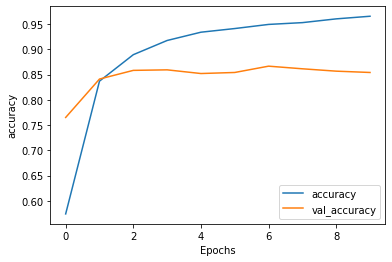

In [31]:
plot_graphs(history, 'accuracy')

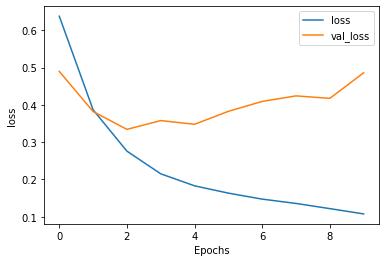

In [32]:
plot_graphs(history, 'loss')

## 堆叠两个或更多 LSTM 层
Keras 循环层有两种可用的模式，这些模式由 return_sequences 构造函数参数控制：

返回每个时间步骤的连续输出的完整序列（形状为 (batch_size, timesteps, output_features) 的 3D 张量）。
仅返回每个输入序列的最后一个输出（形状为 (batch_size, output_features) 的 2D 张量）。

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
________________________________________________

In [34]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 93s 218ms/step - loss: 0.6903 - accuracy: 0.5000 - val_loss: 0.5165 - val_accuracy: 0.7312
Epoch 2/10
391/391 [==============================] - 86s 216ms/step - loss: 0.4557 - accuracy: 0.7921 - val_loss: 0.3921 - val_accuracy: 0.8010
Epoch 3/10
391/391 [==============================] - 86s 218ms/step - loss: 0.2868 - accuracy: 0.8910 - val_loss: 0.3510 - val_accuracy: 0.8536
Epoch 4/10
391/391 [==============================] - 86s 218ms/step - loss: 0.2248 - accuracy: 0.9211 - val_loss: 0.3528 - val_accuracy: 0.8547
Epoch 5/10
391/391 [==============================] - 87s 221ms/step - loss: 0.1870 - accuracy: 0.9369 - val_loss: 0.3956 - val_accuracy: 0.8521
Epoch 6/10
391/391 [==============================] - 85s 216ms/step - loss: 0.1578 - accuracy: 0.9505 - val_loss: 0.3927 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 85s 214ms/step - loss: 0.1333 - accuracy: 0.9601 - val_loss: 0.4428 - val_ac

In [35]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 35s 90ms/step - loss: 0.5459 - accuracy: 0.8350
Test Loss: 0.5458588600158691
Test Accuracy: 0.8350399732589722


In [36]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.9367115]]


In [37]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-4.1747594]]


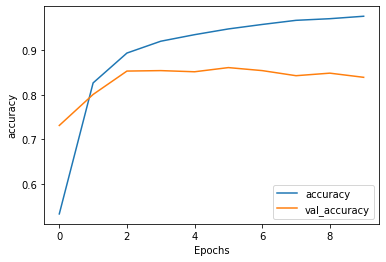

In [38]:
plot_graphs(history, 'accuracy')

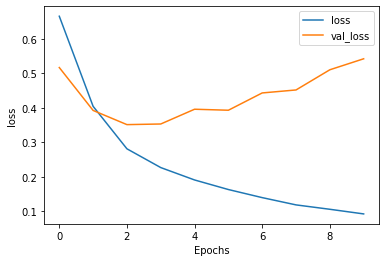

In [39]:
plot_graphs(history, 'loss')
